In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics import r2_score, rmse, mape, ape
from darts import concatenate

from darts.models import XGBModel

In [ ]:
# !pip install "u8darts[all]"

In [8]:
import darts
print(darts.__version__)


# import numpy
# numpy.version.version

0.34.0


## Data Processing

In [2]:
# Add NDBC data here

df1 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2017.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df2 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2016.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df3 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2015.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df4 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2014.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df5 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2013.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)

# Cleaning
def wrangle(df):
    df = df.copy()
    
    # drop the columns where there is no data for all of the 5 years
    cols = ['DEWP',	'VIS',	'TIDE', 'DPD']
    df.drop(columns=cols, inplace=True)
    
    # Drop the first two rows to make it only data from the year we want
    df = df.iloc[2:]

    # Reset the index
    df = df.reset_index()
    df.drop(columns='index', inplace=True)

    #Puts the date togetehr
    df['Date'] = df['#YY'] + '-' + df['MM'] + '-' + df['DD'] + ' ' + df['hh'] + ':' + df['mm']

    #converts date to a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    # # Set the date as the index
    df = df.set_index('Date')
    df.head()

    # We can now remove the columns '#YY', 'DD', 'hh' * Leaving MM and hh because wind might be stronger in the morning than late at night or have seasonal variations.
    cols = ['#YY', 'DD', 'mm']
    df.drop(columns=cols, inplace=True)

    # Make the fataframe contain numberic values instrad of objects
    df = df.apply(lambda x: pd.to_numeric(x), axis=0)

    return df

df1 = wrangle(df1)
df2 = wrangle(df2)
df3 = wrangle(df3)
df4 = wrangle(df4)
df5 = wrangle(df5)

# Combine all of the dataframes into one
frames = [df5, df4, df3, df2, df1]
df = pd.concat(frames)

df.head()

,MM,hh,WDIR,WSPD,GST,WVHT,APD,MWD,PRES,ATMP,WTMP
Date,,,,,,,,,,,
2013-01-01 00:50:00,1,0,345,10.3,12.0,3.71,8.79,314,1017.4,22.1,24.1
2013-01-01 01:50:00,1,1,357,9.4,11.8,4.03,9.16,330,1017.9,22.4,24.1
2013-01-01 02:50:00,1,2,351,9.9,12.1,4.27,9.09,327,1018.7,22.3,24.1
2013-01-01 03:50:00,1,3,358,10.4,12.3,4.08,8.50,326,1019.3,22.1,24.1
2013-01-01 04:50:00,1,4,354,9.7,11.5,4.04,8.74,318,1020.0,21.9,24.1


## XGBoost

### Single Forecast

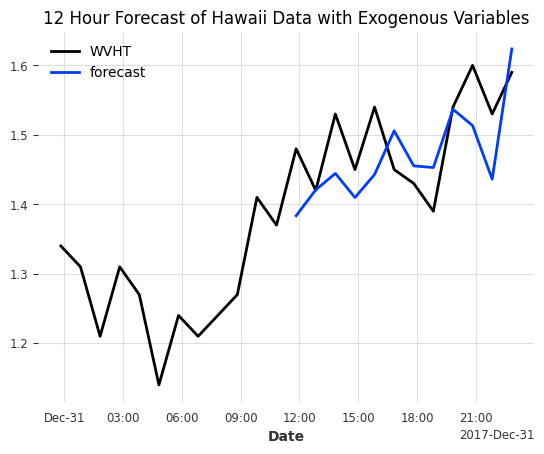

R²: -0.0219
RMSE: 0.0663
Mean Absolute Percent Error: 3.7721%
APE:  [6.51262773 0.06034038 5.58976441 2.77541095 6.30276791 3.8457854
 1.77046269 4.52849402 0.20989598 5.41585535 6.13362368 2.12054043]


In [ ]:
# Single Forecast

# *** Set how many hours to predict ***
p_hours = 12
lags = 12

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df,None, "WVHT", fill_missing_dates=True, freq='H')

# Start training sample (2013 has a big gap)
train_start = pd.Timestamp('12/31/2014')
series = series[train_start:]
# series.add_datetime_attribute("hour")

# Linear Interpolation of missing values
series = fill_missing_values(series)



# Create training and testing data (used val instead of test bcs darts documentation does, sorry if it's confusing)
train, val = series[:-p_hours], series[-p_hours:]

# Create Exogenous Variables Time Series
past_cov = TimeSeries.from_dataframe(df[['WDIR', 'WSPD','GST', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP']], fill_missing_dates=True, freq='H')
past_cov = fill_missing_values(past_cov)
past_cov_train = past_cov[:-p_hours]

# Initialize model (If output chunks < predict length, model starts dynamically forecasting on itself)
model = XGBModel(
    lags=lags,
    lags_past_covariates = lags,
    output_chunk_length=p_hours,
    
    # add_encoders={
    #     'datetime_attribute': {'past' : ['hour']},
    #     'cyclic': {'past': ['month']}
    # }
)

# Fit Model
model.fit(train, 
        past_covariates=past_cov_train
        )
pred = model.predict(len(val))

# Plot Results
series[-(p_hours*2):].plot()
pred.plot(label="forecast")
plt.legend()
plt.title(f'{p_hours} Hour Forecast of Hawaii Data with Exogenous Variables')
plt.show()

# Calculate Error Metrics
r2 = r2_score(val, pred)
rmse_value = rmse(val, pred)
MAPE = mape(val, pred)
APE = ape(val, pred)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"Mean Absolute Percent Error: {MAPE:.4f}%")
print('APE: ', APE)



### Manual Rolling Forecast (old)

This is predicting the next [p_hours] days based on the last [lags] time over and over for a month. A better way to test the model may be to take random time intervals.

In [182]:
# Data

# Create a TimeSeries, specifying the time and value columns (again)
series = TimeSeries.from_dataframe(df,None, "WVHT", fill_missing_dates=True, freq='H')

train_start = pd.Timestamp('12/31/2015') #Less Training Data (increased MAPE by like .5% but doesn't seem to impact training time)
series = series[train_start:]

# Linear Interpolation of missing values
series = fill_missing_values(series)

# Difference from before: Use a timestamp, not a window
val_start = pd.Timestamp('12/01/2017')

# Difference: Use timestamp instead of set amount
train, val = series[:val_start], series[val_start:]

# Create Exogenous Variables Time Series
past_cov = TimeSeries.from_dataframe(df[['WDIR', 'WSPD','GST', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP']], fill_missing_dates=True, freq='H')
past_cov = past_cov[train_start:]
past_cov = fill_missing_values(past_cov)

In [ ]:
# Set Prediction Window
p_hours = 12
lags = 5

rolling_train = train
pred_start = val_start 
rolling_val = val[:pred_start + pd.Timedelta(hours=p_hours)]


rolling_pred = train[-1]       #so it is a time series that starts at the same point as val
with tqdm(total = len(val)//p_hours, desc='Rolling Prediction') as pbar:
    while (pred_start <= val.time_index[-p_hours]):
        
        # Fit model and make prediction
        model = XGBModel(lags=lags, 
                        lags_past_covariates = lags, 
                        output_chunk_length=p_hours)
        model.fit(rolling_train, past_covariates= past_cov)
        p = model.predict(p_hours)
        
        # Save Prediction 
        rolling_pred = rolling_pred.concatenate(p, axis=0)

        
        # Update history
        rolling_train = rolling_train[p_hours:].concatenate(rolling_val ,axis=0)        # shift train by p_hours
        
        pred_start = pred_start+pd.Timedelta(hours=p_hours)
        rolling_val = val[pred_start : pred_start + pd.Timedelta(hours=p_hours)]        #shift rolling val by p_hours (rolling val isn't actually used except to update train, idk why i did it this way)
        # Note: past_cov does not need to be updated because predict automatically only takes what it needs- you can test this by adding it to the single use predict (it changes nothing)
        
        pbar.update(1)
        
rolling_pred = rolling_pred[1:]

Rolling Prediction: 100%|██████████| 61/61 [02:53<00:00,  2.85s/it]


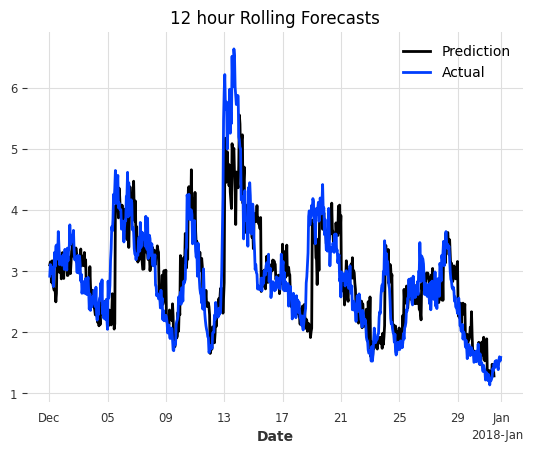

R²: -0.0219
RMSE: 0.0663
Mean Absolute Percent Error: 3.7721%


In [57]:
from darts.metrics import r2_score, rmse,mape

rolling_pred.plot(label='Prediction')
val.plot(label='Actual')
plt.title(f'{p_hours} hour Rolling Forecasts')
plt.show()

r2 = r2_score(val, pred)
rmse_value = rmse(val, pred)
MAPE = mape(val, pred)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"Mean Absolute Percent Error: {MAPE:.4f}%")

    Hour        R²      RMSE       MAPE
0      1  0.930954  0.259235   5.512363
1      2  0.915036  0.270252   7.003103
2      3  0.908535  0.278193   6.334817
3      4  0.871910  0.348208   9.301277
4      5  0.744091  0.451413  10.129641
5      6  0.769620  0.427306  12.503420
6      7  0.616491  0.555614  14.281665
7      8  0.612915  0.530437  13.577495
8      9  0.627796  0.553956  14.306705
9     10  0.494494  0.638246  16.626643
10    11  0.500505  0.688874  17.638373
11    12  0.431248  0.712237  19.166265


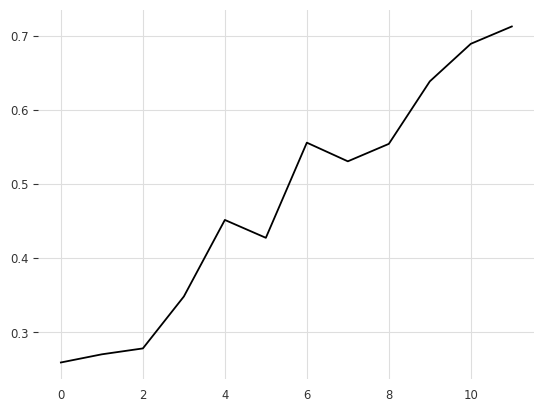

In [186]:
# Create separate forecasts for each step in the prediction window
val_match = val[:-11]

forecasts_by_hour = [rolling_pred[i::p_hours] for i in range(p_hours)]
actual_by_hour = [val_match[i::p_hours] for i in range(p_hours)]

# Compare
errors = []
for i in range(p_hours):
    forecast = forecasts_by_hour[i]
    actual = actual_by_hour[i]

    r2 = r2_score(actual, forecast)
    rmse_value = rmse(actual, forecast)
    mape_value = mape(actual, forecast)

    errors.append({
        'Hour': i + 1,
        'R²': r2,
        'RMSE': rmse_value,
        'MAPE': mape_value
    })

# Convert to DataFrame
error_df = pd.DataFrame(errors)
print(error_df)

plt.plot(error_df['RMSE'])

    Hour        R²      RMSE       MAPE
0      1  0.930954  0.259235   5.512363
1      2  0.915036  0.270252   7.003103
2      3  0.908535  0.278193   6.334817
3      4  0.871910  0.348208   9.301277
4      5  0.744091  0.451413  10.129641
5      6  0.769620  0.427306  12.503420
6      7  0.616491  0.555614  14.281665
7      8  0.612915  0.530437  13.577495
8      9  0.627796  0.553956  14.306705
9     10  0.494494  0.638246  16.626643
10    11  0.500505  0.688874  17.638373
11    12  0.431248  0.712237  19.166265



### Backtest
same as rolling_pred but using darts historical_forecasts library.

In [ ]:
# !pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 22.1 MB/s eta 0:00:00


#### 12 hours

In [ ]:
# *** Set how many hours to predict ***
p_hours = 12
lags = 5
val_start = '12/01/2017 00:50:00'  # when to start forecasting

# Data
# Create a TimeSeries, specifying the time and value columns (again)
series = TimeSeries.from_dataframe(df,None, "WVHT", fill_missing_dates=True, freq='H')

train_start = pd.Timestamp('12/31/2015') #Less Training Data (increased MAPE by like .5% but doesn't seem to impact training time)
series = series[train_start:]

# Linear Interpolation of missing values
series = fill_missing_values(series)

# Create Exogenous Variables Time Series
past_cov = TimeSeries.from_dataframe(df[['WDIR', 'WSPD','GST', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP']], fill_missing_dates=True, freq='H')
past_cov = past_cov[train_start:]

# Initialize model (If output chunks < predict length, model starts dynamically forecasting on itself)
model = XGBModel(
    lags=lags,
    lags_past_covariates = lags,
    output_chunk_length=p_hours,
    
    # add_encoders={
    #     'datetime_attribute': {'past' : ['hour']},
    #     'cyclic': {'past': ['month']}
    # }
)

hist = model.historical_forecasts(
    series,
    past_covariates=past_cov,
    forecast_horizon=p_hours,
    stride=p_hours,
    start= pd.Timestamp(val_start),
    retrain=True,
    last_points_only = False,
    enable_optimization=False,
    verbose=True  
    ) 

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

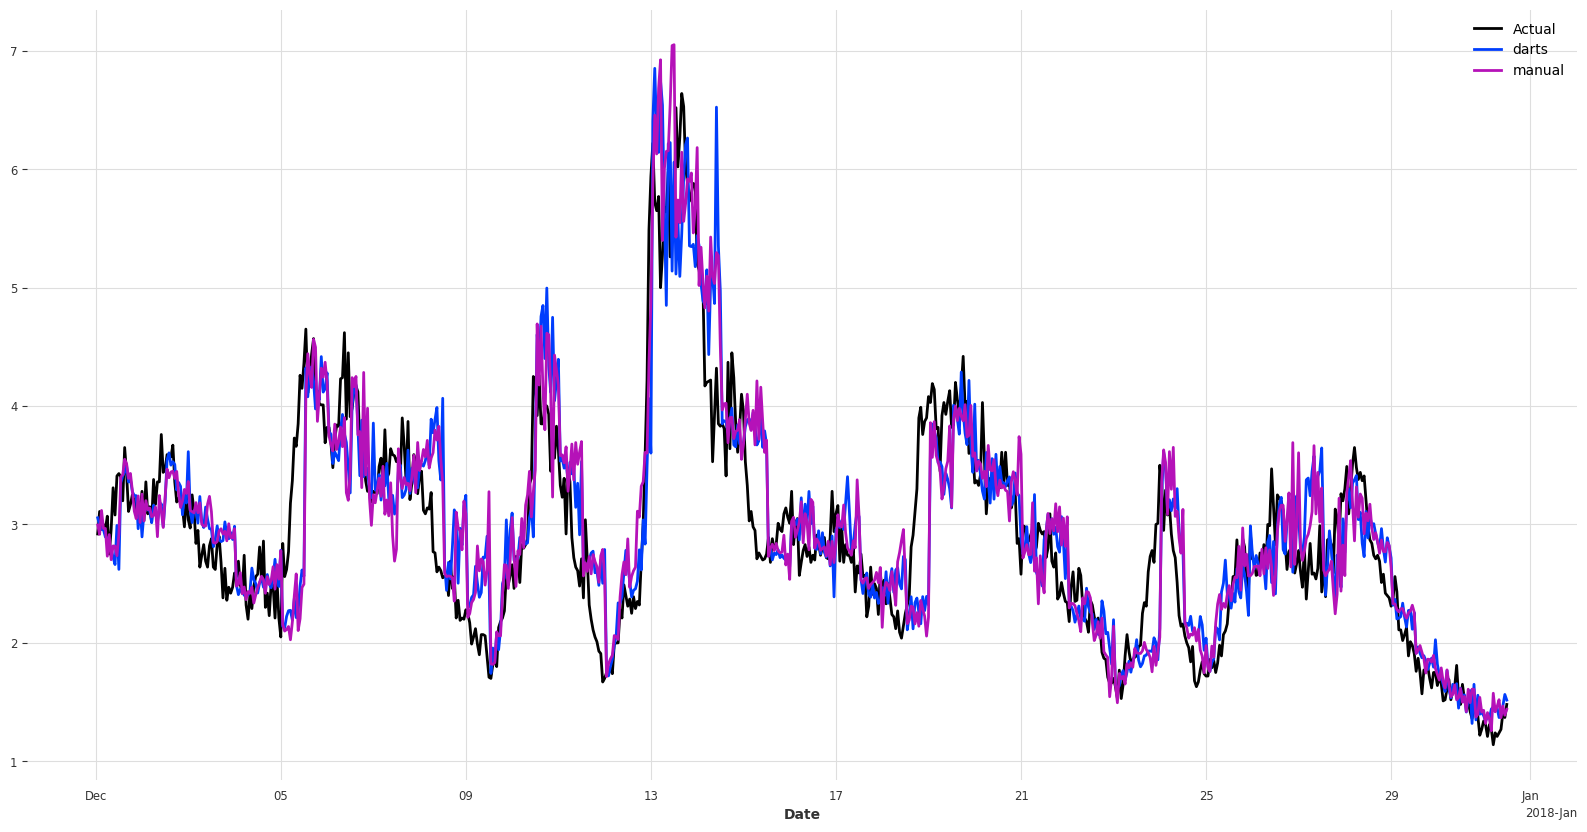

In [ ]:
# Flatten hist
hist_all = concatenate(hist, axis=0)
val_match = val[pd.Timestamp('12/01/2017'):hist_all[-1].get_timestamp_at_point(0)]

plt.figure(figsize=(20,10))
val_match.plot(label = 'Actual')
hist_all.plot(label = 'darts')
rolling_pred.plot(label = 'manual')
plt.show()

    Hour        R²      RMSE       MAPE
0      1  0.923250  0.273316   5.682831
1      2  0.918691  0.264376   6.627267
2      3  0.883490  0.313979   6.701727
3      4  0.837331  0.392404  10.050671
4      5  0.786475  0.412340   9.905745
5      6  0.752916  0.442526  12.134896
6      7  0.702885  0.489044  13.055279
7      8  0.610910  0.531809  12.465181
8      9  0.611854  0.565695  15.853444
9     10  0.492922  0.639238  16.490588
10    11  0.588202  0.625484  16.323819
11    12  0.418415  0.720227  18.717213


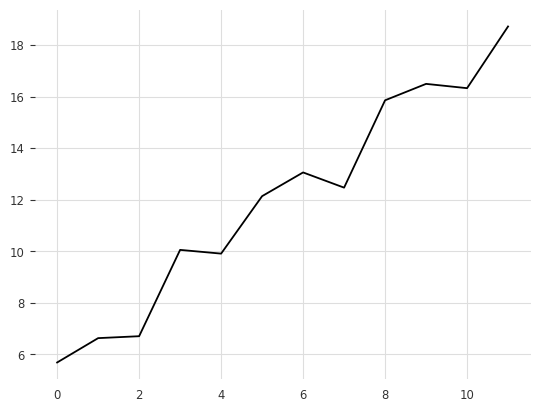

In [252]:

# Create separate forecasts for each step in the prediction window

forecasts_by_hour = [hist_all[i::p_hours] for i in range(p_hours)]
actual_by_hour = [val_match[i::p_hours] for i in range(p_hours)]

# Compare
errors = []
for i in range(p_hours):
    forecast = forecasts_by_hour[i]
    actual = actual_by_hour[i]

    r2 = r2_score(actual, forecast)
    rmse_value = rmse(actual, forecast)
    mape_value = mape(actual, forecast)

    errors.append({
        'Hour': i + 1,
        'R²': r2,
        'RMSE': rmse_value,
        'MAPE': mape_value
    })

# Convert to DataFrame
error_df = pd.DataFrame(errors)
print(error_df)
plt.plot(error_df['MAPE'])




#### 24 hours

In [ ]:
# *** Set how many hours to predict ***
p_hours = 24
lags = 12      
val_start = '12/01/2017 00:50:00'  # when to start forecasting


# Data
# Create a TimeSeries, specifying the time and value columns (again)
series = TimeSeries.from_dataframe(df,None, "WVHT", fill_missing_dates=True, freq='H')

train_start = pd.Timestamp('12/31/2015') #Less Training Data (increased MAPE by like .5% but doesn't seem to impact training time)
series = series[train_start:]

# Linear Interpolation of missing values
series = fill_missing_values(series)

# Create Exogenous Variables Time Series
past_cov = TimeSeries.from_dataframe(df[['WDIR', 'WSPD','GST', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP']], fill_missing_dates=True, freq='H')
past_cov = past_cov[train_start:]

# Initialize model (If output chunks < predict length, model starts dynamically forecasting on itself)
model = XGBModel(
    lags=lags,
    lags_past_covariates = lags,
    output_chunk_length=p_hours,
    
    # add_encoders={
    #     'datetime_attribute': {'past' : ['hour']},
    #     'cyclic': {'past': ['month']}
    # }
)

hist = model.historical_forecasts(
    series,
    past_covariates=past_cov,
    forecast_horizon=p_hours,
    stride=p_hours,
    start= pd.Timestamp(val_start),
    retrain=True,
    last_points_only = False,
    enable_optimization=False,
    verbose=True  
    ) 

historical forecasts:   0%|          | 0/30 [00:00<?, ?it/s]

            R²      RMSE       MAPE
Hour                               
1     0.957157  0.197699   4.849674
2     0.905329  0.270999   7.583581
3     0.905966  0.265328   6.257855
4     0.845706  0.340667   9.285970
5     0.709570  0.407749  10.199674
6     0.695601  0.422940  11.037490
7     0.655509  0.493424  12.815330
8     0.601799  0.504162  11.533039
9     0.594530  0.577272  16.164108
10    0.380175  0.657499  15.998140
11    0.446487  0.675091  16.520074
12    0.227667  0.752987  18.518225
13    0.496645  0.699538  18.490746
14    0.496228  0.662594  17.794571
15    0.275375  0.797297  19.762188
16    0.379787  0.815472  22.844737
17    0.379912  0.764067  20.015515
18    0.392344  0.751474  20.077217
19    0.287132  0.771061  22.764325
20    0.189215  0.779192  20.943694
21    0.266960  0.748641  20.451659
22    0.134323  0.864965  24.358687
23    0.366058  0.805854  24.487305
24    0.343919  0.813621  24.597642


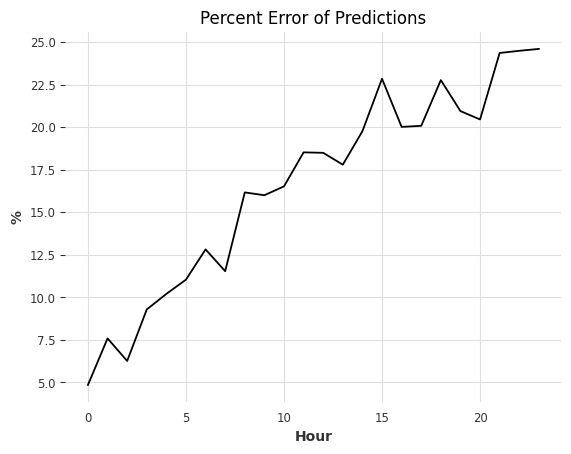

In [ ]:
# Flatten hist
hist_all = concatenate(hist, axis=0)
val_match = val[pd.Timestamp('12/01/2017'):hist_all[-1].get_timestamp_at_point(0)]

# Create separate forecasts for each step in the prediction window
forecasts_by_hour = [hist_all[i::p_hours] for i in range(p_hours)]
actual_by_hour = [val_match[i::p_hours] for i in range(p_hours)]

# Compare
errors = []
for i in range(p_hours):
    forecast = forecasts_by_hour[i]
    actual = actual_by_hour[i]

    r2 = r2_score(actual, forecast)
    rmse_value = rmse(actual, forecast)
    mape_value = mape(actual, forecast)

    errors.append({
        'Hour': i + 1,
        'R²': r2,
        'RMSE': rmse_value,
        'MAPE': mape_value
    })

# Convert to DataFrame
error_df = pd.DataFrame(errors)
print(error_df.set_index('Hour'))

plt.plot(error_df['MAPE'])
plt.title('Percent Error of Predictions')
plt.xlabel('Hour')
plt.ylabel('%')
plt.show()

In [ ]:
# Calculates overall metrics(not sure how useful this is)
model = XGBModel(
    lags=lags,
    lags_past_covariates = lags,
    output_chunk_length=p_hours,
)

model.backtest(
    series,
    past_covariates=past_cov,
    historical_forecasts = hist,
    metric = [rmse, mape],
    last_points_only=False,
    
    )

array([ 0.56840604, 16.55631027])